# Transport model under steady state

Assuming steady state ($J=Q$), the outflow conentration $C_Q$ of a hydrologic system can be written as:

<br>

&emsp;$C_Q(t) = \int_{0}^{\infty} C_J(t-T) p_Q(T) dT$

<br>

where $C_J(t)$ is the inflow conentration and $p_Q$ is the transit time distribution (TTD). The above model is a [convolution](https://en.wikipedia.org/wiki/Convolution) model.

<br>

In this exercise, we will study how to estimate $C_Q$ using $C_J$ and TTD ($p_Q$). We will also examine how the time series of $C_Q$ varies depending on the TTD and $C_Q$. You will first define $C_J$ and TTD. Then, you will calculate $C_Q$.
At last, you will create an interactive plot that shows $C_J$ and $C_Q$ depening on your choice of $C_J$ and $TTD$.


# 1. Define the inflow conentration

Let's first define $C_J$. We will assume the inflow concentration is a sine curve with a random component term $b$ as:

<br>

&emsp;$C_J(t) = sin(\frac{2 \pi t}{t_{wl}}) + a + b$

<br>

where $t_{wl}$, $a$, $b \sim N(0,\sigma)$, $N$ is the Gaussian distribution, and $\sigma$ is the standard deviation.

<br>

In general, we solve a model numerically, and it requires 'discretization'. Also, regarding the input concentration (which is usually assocated with rainfall), we usually measure daily or weekly "average" concetration. In this example, we will assume that the average concentartion as: 

<br>

&emsp;$C_{J,D}(t) = C_J([t])$ 

<br>

where $[x]$ is the round (half up) operator which gives the integer closest to $x$ (rounding up for half-integer values).

<br>

The following code define 5 years of $C_J$ and will generate two plots. The top plot shows the $C_{J,D}$ for the entire period. The bottom plot shows the $C_{J,D}$ and $C_J$ for $t \in$ [0, 5 days]. Take a look at how $C_{J,D}$ is discretized.



(2.8499999999999996, 3.222242548142436)

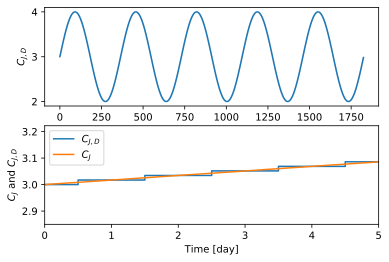

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(0,365*5-1,365*5)

twl = 365.
a = 3.

random_component = np.random.rand(len(t)) * 0.0
CJ = np.sin(t/twl*2*np.pi) + random_component + a 

figM = plt.figure(1)
ax = figM.add_subplot(211)
ax.step(t,CJ, where = 'mid')
ax.set_ylabel(r'$C_{J,D}$')

ax = figM.add_subplot(212)
ax.step(t,CJ, where = 'mid',label = r'$C_{J,D}$')
ax.plot(t,CJ, label = r'$C_J$')
ax.legend()
ax.set_ylabel(r'$C_J$ and $C_{J,D}$' )
ax.set_xlabel('Time [day]')
ax.set_xlim([0,5])
ax.set_ylim([np.min(CJ[:5]) * 0.95, np.max(CJ[:5]) * 1.05])

# 2. Define the transit time distribution

Let's define the transit time distribution (TTD). In this exercise, the TTD is the exponential distribution with the mean transit time $T_m$ as:

<br>

&emsp;$p_Q(T) = \frac{1}{T_m} e^{-T/T_m}$

<br>

We will also discretize the TTD. In this example, we will use the cumulative distribution to discretize the TTD. The cumulative TTD $P_Q(T)$ can be written as:

<br>

&emsp;$P_Q(T) = \int_{0}^{T} p_Q(\tau) d\tau = 1 - e^{-T/T_m}$

<br>

Using the cumulative TTD, we can define the discretized p_{Q,D} as:

<br>

&emsp;$p_{Q,D}(T) = (P_Q([T] + \Delta T/2) - P_Q([T] -\Delta T/2))/\Delta T$

<br>

where $\Delta T$ is the time-step.

(0.009405512610138689, 0.010395566569100656)

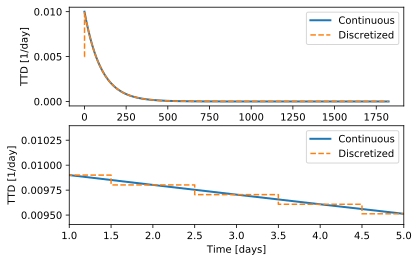

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mTT = 100.
TTD = 1/mTT * np.exp(-(t)/mTT)
figM = plt.figure()
ax = figM.add_subplot(211)
ax.plot(t,TTD,lw=2, label = 'Continuous')
ax.set_ylabel('TTD [1/day]')
ax.set_xlabel('Time [days]')

cTTD = 1.- np.exp(-np.append(0,t+0.5)/mTT)
TTD_disc = np.diff(cTTD)
ax.step(t,TTD_disc,where='mid',ls='dashed', label = 'Discretized')
ax.legend()

ax = figM.add_subplot(212)
ax.plot(t,TTD,lw=2, label = 'Continuous')
ax.set_ylabel('TTD [1/day]')
ax.set_xlabel('Time [days]')
ax.step(t,TTD_disc,where='mid',ls='dashed', label = 'Discretized')
ax.legend()
ax.set_xlim([1,5])
ax.set_ylim([TTD_disc[1]*0.95,TTD_disc[1]*1.05])

#plt.xlim([5,20])
#plt.ylim([0.008,0.01])

# 3. Estimate the outflow concentration

When $C_J$ and $p_Q$ are known, we can estimate the outflow concentration $C_Q$ as:

&emsp;$C_Q(t) = \int_{0}^{\infty} C_J(t-T) p_Q(T) dT$


Since we do not have entire time series of $C_J$ (i.e., $C_J(t)$ is available only for $t \ge 0$), $C_Q$ can only be estimate from the day $t_r$ where $\int_{t_r}^{\infty} C_J(t-T) p_Q(T) dT \approx 0$. 

In the following code, we will use the <i>convolve</i> function in the <i>numpy</i> library. We will determine $t_r$ as the smallest interger where $P_Q(t_r) > 0.999$. Again, $C_Q$ is only accuarate enough after $t_r$. 


We will check the quality of the numerical solution with the anayltical solution. For the case discussed above, the analytical solution of $C_Q$ is:

&emsp;$C_Q(t) = \frac{a (4 T_m^2 \pi^2 + T_w^2) - 2T_m \pi T_w \cos(\frac{2\pi t}{T_w}) + T_w^2 \sin(\frac{2 \pi t}{T_w})}{4 T_m^2 \pi^2 + T_w^2}$

Let's check if the numerical solution matches the analytical solution.

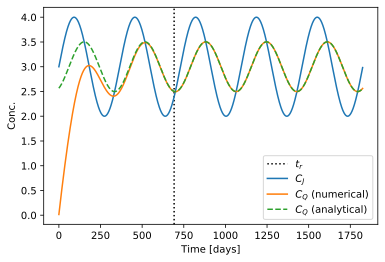

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

remove_spinup = next(x[0] for x in enumerate(cTTD) if x[1] > 0.999)

CQ = np.convolve(TTD_disc,CJ)[:len(t)]#[remove_spinup:len(t)]
CQ_analytic = (a*(4*np.power(mTT,2)*np.power(np.pi,2) + np.power(twl,2)) - 2. * mTT * np.pi * twl * np.cos(2*np.pi*t/twl) + np.power(twl,2) * np.sin(2*np.pi*t/twl)) / (4*np.power(mTT,2)*np.power(np.pi,2) + np.power(twl,2))

#plt.plot(t[remove_spinup:],CJ[remove_spinup:len(t)], label = r'$C_J$')
#plt.plot(t[remove_spinup:],CQ, label = r'$C_Q$ (numerical)')
#plt.plot(t[remove_spinup:],CQ_analytic[remove_spinup:], ls = 'dashed', label = r'$C_Q$ (analytical)')

plt.axvline(remove_spinup, c = 'k', ls = 'dotted', label = r'$t_r$')
plt.plot(t,CJ, label = r'$C_J$')
plt.plot(t,CQ, label = r'$C_Q$ (numerical)')
plt.plot(t,CQ_analytic, ls = 'dashed', label = r'$C_Q$ (analytical)')


plt.ylabel('Conc.')
plt.xlabel('Time [days]')
plt.legend()

# 4. Create an interactive plot

We will create an interactive plot using what we have learend so far. If you are not interested in taking look at the following code, that is okay. Just run the below code.

In [19]:
%matplotlib notebook
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

import numpy as np

rand = 0.0 #Init
random_component = np.random.randn(len(t)) * rand

rand_prev = rand

def plot_func(mTT,twl,a, rand):
    %matplotlib notebook

    global rand_prev, random_component
    if rand_prev != rand:
        random_component = np.random.randn(len(t)) * rand
        rand_prev = rand
        
    CJ = np.sin(t/twl*2*np.pi) + random_component + a 
    cTTD = 1.- np.exp(-np.append(0,t+0.5)/mTT)    
    TTD_disc = np.diff(cTTD)    
    remove_spinup = next(x[0] for x in enumerate(cTTD) if x[1] > 0.999)

    CQ = np.convolve(TTD_disc,CJ)[remove_spinup:len(t)]
    CQ_analytic = (a*(4*np.power(mTT,2)*np.power(np.pi,2) + np.power(twl,2)) - 2. * mTT * np.pi * twl * np.cos(2*np.pi*t/twl) + np.power(twl,2) * np.sin(2*np.pi*t/twl)) / (4*np.power(mTT,2)*np.power(np.pi,2) + np.power(twl,2))

    figM = plt.figure(1)
    ax = figM.add_subplot(211)
#    ax.plot(t[remove_spinup:],CJ[remove_spinup:len(t)], alpha = 0.5)
    ax.plot(t,CJ, alpha = 0.5, label = r'$C_J$')
    ax.plot(t[remove_spinup:],CQ, label = r'$C_Q$')
    ax.plot(t[remove_spinup:],CQ_analytic[remove_spinup:], ls = 'dashed', label = r'$C_Q$ (analytical)')
    ax.set_ylabel('Conc.')
    ax.legend()
    ax = figM.add_subplot(212)
    TTD = 1/mTT * np.exp(-(t)/mTT)
    ax.plot(t,TTD)
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('TTD [1/day]')
    
interact(plot_func, mTT = widgets.FloatSlider(value=100.,
                                               min=20,
                                               max=200.0,
                                               step=20,description = r'$T_m$'), 
         twl  = widgets.FloatSlider(value = 365.,min= 60,max=365*5,step = 120, description = r'$T_{wl}$'), 
         a    = widgets.FloatSlider(value = 10., min= 0,max=50,step = 10, description = r'$a$'),  
         rand = widgets.FloatSlider(value = 0., min= 0,max=10,step = 1, description = r'$\sigma$'))

interactive(children=(FloatSlider(value=100.0, description='$T_m$', max=200.0, min=20.0, step=20.0), FloatSlid…

<function __main__.plot_func(mTT, twl, a, rand)>

# Tasks

1. Under which setting, is $C_Q$ largely damped compared to $C_J$, and why?

2. What was the role of the analytical solution in this notebook?


# Advanced tasks

1. Why the peak of $C_Q$ falls onto $C_J$ when $\sigma$ = 0?

2. In general, what we can measure are the concentration time series $C_Q$ and $C_J$, and we are interested in estimating TTD. How can we do that?